In [ ]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt


In [ ]:
nifty_df9 = pd.read_csv('/content/NIFTY 50-24-03-2015-to-15-03-2016.csv')
nifty_df1 = pd.read_csv('/content/NIFTY 50-16-03-2016-to-16-03-2017.csv')
nifty_df2 = pd.read_csv('/content/NIFTY 50-17-03-2017-to-17-03-2018.csv')
nifty_df3 = pd.read_csv('/content/NIFTY 50-18-03-2018-to-18-03-2019.csv')
nifty_df4 = pd.read_csv('/content/NIFTY 50-19-03-2019-to-19-03-2020.csv')
nifty_df5 = pd.read_csv('/content/NIFTY 50-20-03-2020-to-20-03-2021.csv')
nifty_df6 = pd.read_csv('/content/NIFTY 50-21-03-2021-to-21-03-2022.csv')
nifty_df7 = pd.read_csv('/content/NIFTY 50-22-03-2022-to-22-03-2023.csv')
nifty_df8 = pd.read_csv('/content/NIFTY 50-23-03-2023-to-23-03-2024.csv')
nifty_df10 = pd.read_csv('/content/NIFTY 50-24-03-2024-to-24-03-2025.csv')


In [ ]:
data = pd.concat([nifty_df9,nifty_df1,nifty_df2,nifty_df3,nifty_df4,nifty_df5,nifty_df6,nifty_df7,nifty_df8,nifty_df10], axis=0, ignore_index=True)

In [ ]:
data.tail()

,Date,Open,High,Low,Close,Shares Traded,Turnover (₹ Cr)
2474,18-MAR-2025,22662.25,22857.80,22599.20,22834.30,272578844.0,26387.47
2475,19-MAR-2025,22874.95,22940.70,22807.95,22907.60,323992121.0,26994.95
2476,20-MAR-2025,23036.60,23216.70,22973.95,23190.65,313729818.0,27573.99
2477,21-MAR-2025,23168.25,23402.70,23132.80,23350.40,540966316.0,51005.67
2478,24-MAR-2025,23515.40,23708.75,23433.50,23658.35,NaN,NaN


In [ ]:
data.columns

Index(['Date ', 'Open ', 'High ', 'Low ', 'Close ', 'Shares Traded ',
       'Turnover (₹ Cr)'],
      dtype='object')

In [ ]:
high = data['High ']
low = data['Low ']
close = data['Close ']
open = data['Open ']


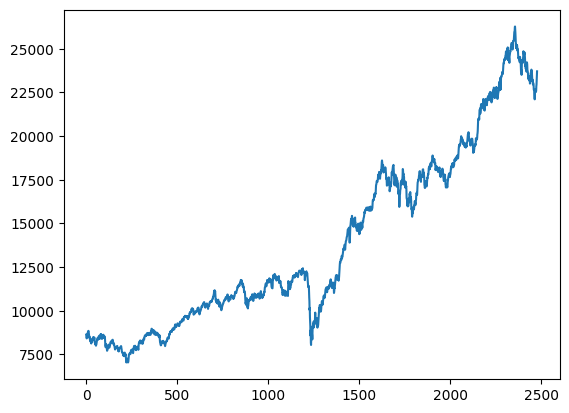

In [ ]:
plt.plot(high)

In [ ]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series):

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [ ]:
check_stationarity(high)

ADF Statistic: 0.365347
p-value: 0.980152
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Non-stationary


# Define non-linear model for de-trending

In [ ]:
import numpy as np
from scipy.optimize import curve_fit

# Define the exponential function for non-linear regression
def exp_growth(t, a, b):
    return a * np.exp(b * t)

def polynomial_growth(t, a, b, c):
    return a * t**2 + b * t + c

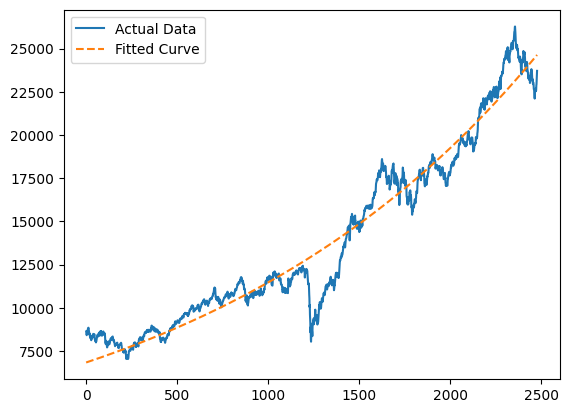

In [ ]:
t = np.arange(len(high))

params, covariance = curve_fit(exp_growth, t, high, p0=[1, 0.01])

# Extract fitted parameters
a_hat, b_hat = params

# Generate predictions
fitted_high = exp_growth(t, a_hat, b_hat)

# Plot original vs. fitted values
plt.plot(t, high, label="Actual Data")
plt.plot(t, fitted_high, label="Fitted Curve", linestyle="dashed")
plt.legend()
plt.show()

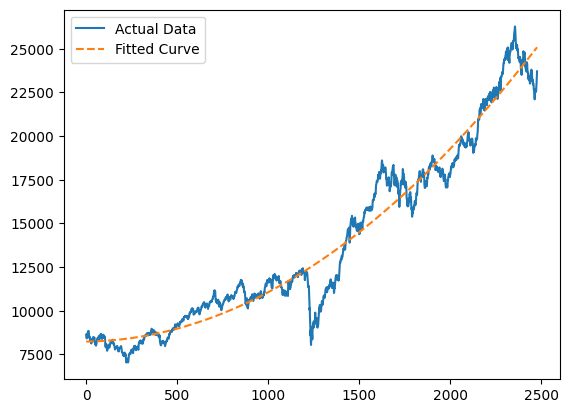

In [ ]:
params, covariance = curve_fit(polynomial_growth, t, high, p0=[1, 0.01, 0.1])
a_hat, b_hat, c_hat = params
fitted_high_polynomial = polynomial_growth(t, a_hat, b_hat, c_hat)


plt.plot(t, high, label="Actual Data")
plt.plot(t, fitted_high_polynomial, label="Fitted Curve", linestyle="dashed")
plt.legend()
plt.show()

## Residual

In [ ]:
exp_resid = high - fitted_high
polynomial_resid = high - fitted_high_polynomial

## Choose best non-linear model

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error

r2 = r2_score(high, fitted_high)
rmse = np.sqrt(mean_squared_error(high, fitted_high))

print(f"R-squared: {r2:.4f}, RMSE: {rmse:.4f}")


R-squared: 0.9487, RMSE: 1163.8046


In [ ]:
from sklearn.metrics import r2_score, mean_squared_error

r2 = r2_score(high, fitted_high_polynomial)
rmse = np.sqrt(mean_squared_error(high, fitted_high_polynomial))

print(f"R-squared: {r2:.4f}, RMSE: {rmse:.4f}")


R-squared: 0.9556, RMSE: 1082.6240


Polynomial model is a better fit

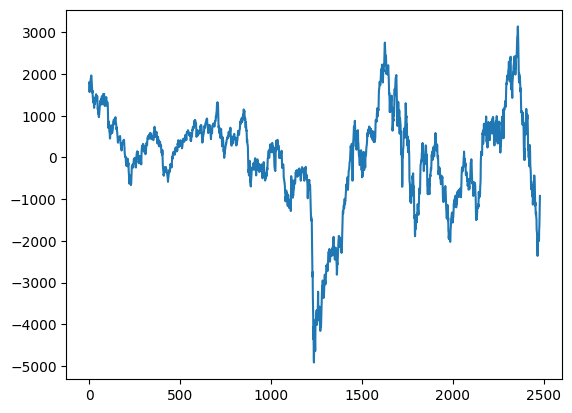

In [ ]:
plt.plot(exp_resid)

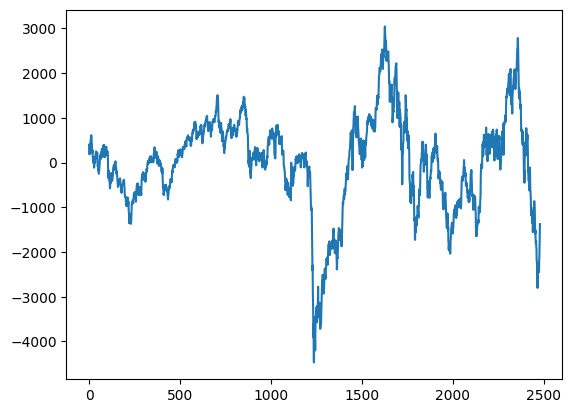

In [ ]:
plt.plot(polynomial_resid)

# Testing for heteroskedasticity

In [ ]:
check_stationarity(exp_resid)

ADF Statistic: -3.035331
p-value: 0.031724
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Stationary


In [ ]:
check_stationarity(polynomial_resid)

ADF Statistic: -2.995010
p-value: 0.035363
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Stationary


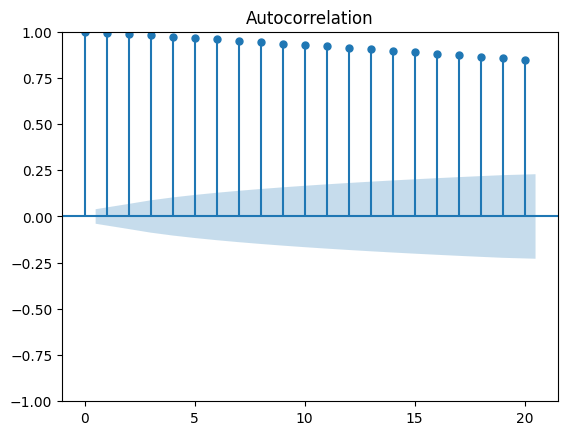

In [ ]:
import statsmodels.api as sm

sm.graphics.tsa.plot_acf(exp_resid, lags=20)
plt.show()

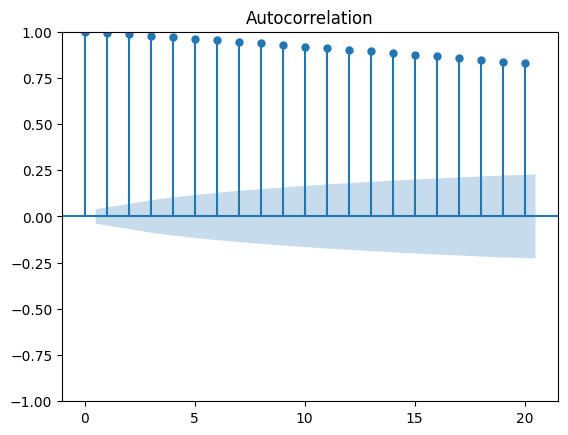

In [ ]:
sm.graphics.tsa.plot_acf(polynomial_resid, lags=20)
plt.show()

## Differencing to make stationary and fitting ARMA

In [ ]:
exp_resid_diff = exp_resid.diff(periods=1).dropna()
polynomial_resid_diff = polynomial_resid.diff(periods=1).dropna()

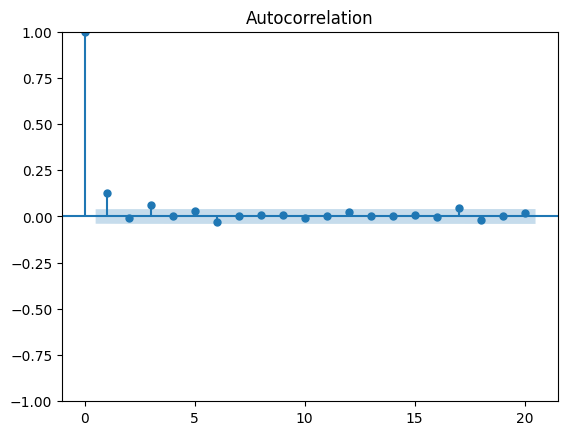

In [ ]:
sm.graphics.tsa.plot_acf(exp_resid_diff, lags=20)
plt.show()

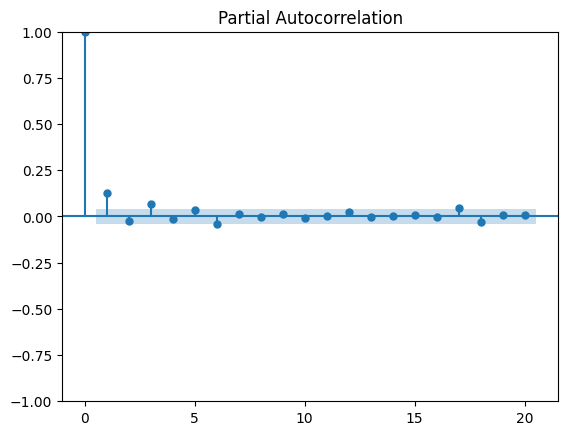

In [ ]:
sm.graphics.tsa.plot_pacf(exp_resid_diff, lags=20)
plt.show()

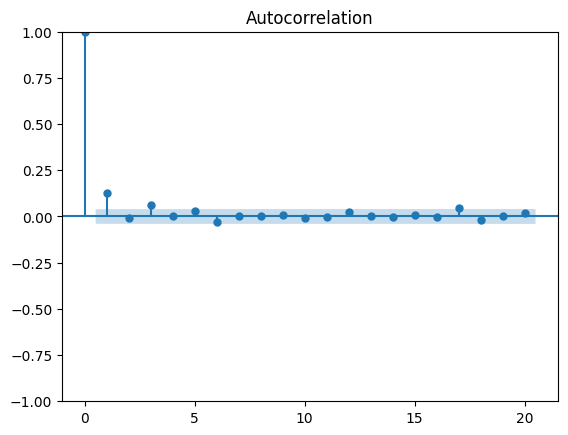

In [ ]:
sm.graphics.tsa.plot_acf(polynomial_resid_diff, lags=20)
plt.show()

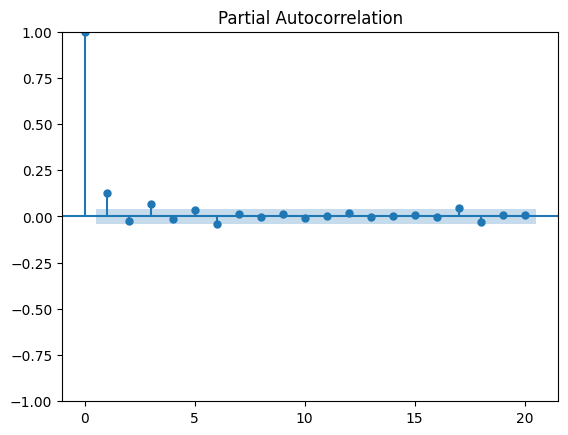

In [ ]:
sm.graphics.tsa.plot_pacf(polynomial_resid_diff, lags=20)
plt.show()

In [ ]:
model = sm.tsa.ARIMA(polynomial_resid_diff, order=(1, 0, 1))
result = model.fit()
polynomial_ARIMA_residuals = result.resid

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


In [ ]:
model = sm.tsa.ARIMA(exp_resid_diff, order=(1, 0, 1))
result = model.fit()
exp_ARIMA_residuals = result.resid

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


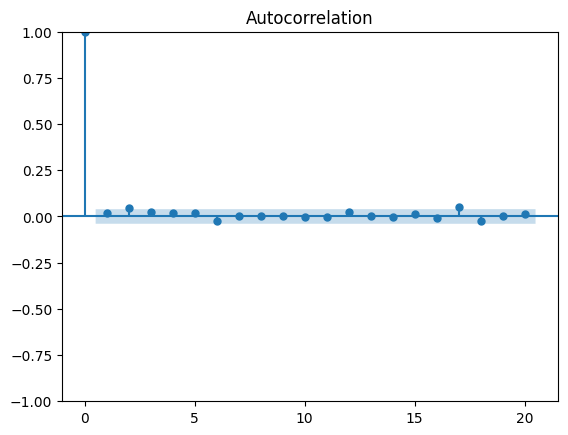

In [ ]:
sm.graphics.tsa.plot_acf(exp_ARIMA_residuals, lags=20)
plt.show()

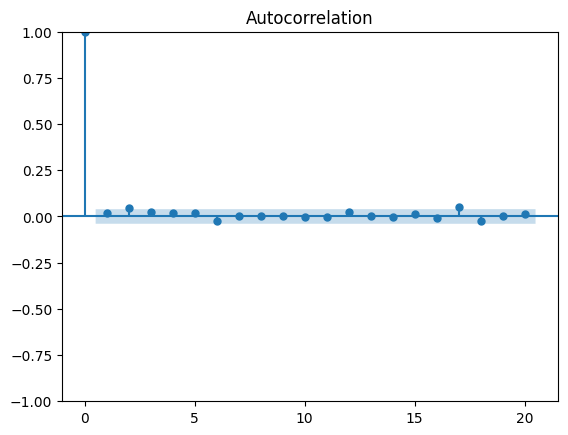

In [ ]:
sm.graphics.tsa.plot_acf(polynomial_ARIMA_residuals, lags=20)
plt.show()

## ARIMA model result

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


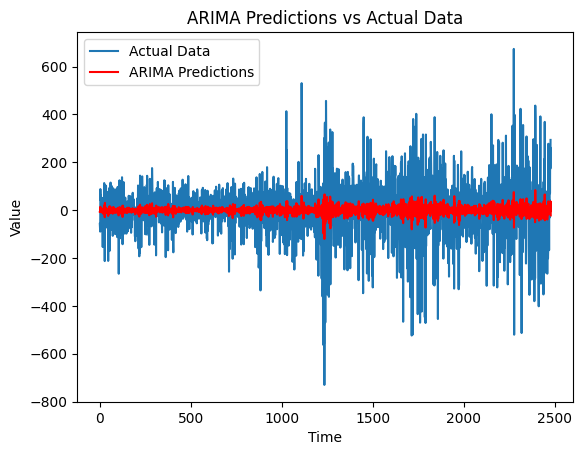

In [ ]:
predictions_ARIMA = result.predict(start=1, end=len(high), dynamic=False)

plt.plot(exp_resid_diff, label="Actual Data")

# Plot ARIMA predictions
plt.plot(predictions_ARIMA, label="ARIMA Predictions", color='red')

# Labels and title
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("ARIMA Predictions vs Actual Data")
plt.legend()
plt.show()

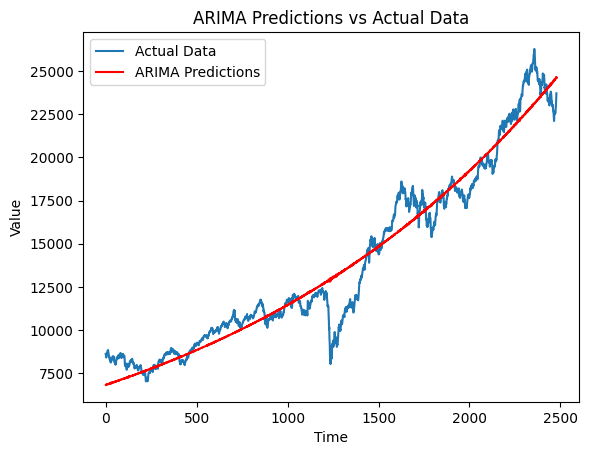

In [ ]:
high_exp_ARIMA = fitted_high + predictions_ARIMA

plt.plot(high, label="Actual Data")

# Plot ARIMA predictions
plt.plot(high_exp_ARIMA, label="ARIMA Predictions", color='red')

# Labels and title
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("ARIMA Predictions vs Actual Data")
plt.legend()
plt.show()

This is the fitted ARIMA plot, as you can see above, the variation predicted by the ARIMA is very small compared to the actual variations. This is because the conditional variance is not constant.

## ARCH Engle's test

In [ ]:
from statsmodels.stats.diagnostic import het_arch

arch_test = het_arch(polynomial_resid_diff, nlags=5)
print(f"LM Statistic: {arch_test[0]}")
print(f"P-value: {arch_test[1]}")


LM Statistic: 326.85896316729156
P-value: 1.6742384476519675e-68


In [ ]:
from statsmodels.stats.diagnostic import het_arch

arch_test = het_arch(exp_resid_diff, nlags=5)
print(f"LM Statistic: {arch_test[0]}")
print(f"P-value: {arch_test[1]}")

LM Statistic: 326.50929371500695
P-value: 1.990921087118017e-68


P-value is < 0.05 hence heteroskedasticity is present

In [ ]:
arch_test = het_arch(polynomial_ARIMA_residuals, nlags=5)
print(f"LM Statistic: {arch_test[0]}")
print(f"P-value: {arch_test[1]}")

LM Statistic: 314.97232702761994
P-value: 6.039284781952912e-66


P-Value is less than 0.05, hence reject the null-hypothesis

In [ ]:
arch_test = het_arch(exp_ARIMA_residuals, nlags=5)
print(f"LM Statistic: {arch_test[0]}")
print(f"P-value: {arch_test[1]}")

LM Statistic: 314.16840328819853
P-value: 8.99292643418511e-66


P-Value is less than 0.05, hence reject the null-hypothesis

Hence, there is Heteroskedasticity

# RNN and analysis

## Data Preprocessing

In [ ]:
data.head()

,Date,Open,High,Low,Close,Shares Traded,Turnover (₹ Cr)
0,24-MAR-2015,8537.05,8627.75,8535.85,8542.95,161465466.0,7913.26
1,25-MAR-2015,8568.90,8573.75,8516.55,8530.80,165952155.0,8200.05
2,26-MAR-2015,8474.95,8499.45,8325.35,8342.15,288758332.0,13667.31
3,27-MAR-2015,8396.00,8413.20,8269.15,8341.40,198979321.0,9528.86
4,30-MAR-2015,8390.95,8504.55,8380.75,8492.30,142061290.0,6713.20


In [ ]:
y = data['High ']
X = data[['Open ', 'Low ', 'Close ', 'Shares Traded ', 'Turnover (₹ Cr)']]

In [ ]:
l = (int)(2479*0.8)
X_train = X.iloc[0:l]
y_train = y.iloc[0:l]
X_test = X.iloc[l:]
y_test = y.iloc[l:]

In [ ]:
print(np.isnan(X).sum(), np.isinf(X).sum())  # Input features
print(np.isnan(y).sum(), np.isinf(y).sum())  # Target


Open               0
Low                0
Close              0
Shares Traded      2
Turnover (₹ Cr)    2
dtype: int64 Open               0
Low                0
Close              0
Shares Traded      0
Turnover (₹ Cr)    0
dtype: int64
0 0


In [ ]:
X

array([[8.53705000e+03, 8.53585000e+03, 8.54295000e+03, 1.61465466e+08,
        7.91326000e+03],
       [8.56890000e+03, 8.51655000e+03, 8.53080000e+03, 1.65952155e+08,
        8.20005000e+03],
       [8.47495000e+03, 8.32535000e+03, 8.34215000e+03, 2.88758332e+08,
        1.36673100e+04],
       ...,
       [2.30366000e+04, 2.29739500e+04, 2.31906500e+04, 3.13729818e+08,
        2.75739900e+04],
       [2.31682500e+04, 2.31328000e+04, 2.33504000e+04, 5.40966316e+08,
        5.10056700e+04],
       [2.35154000e+04, 2.34335000e+04, 2.36583500e+04,            nan,
                   nan]])

## Simple RNN Model

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

# Convert DataFrame columns
y = data['High '].values
X = data[['Open ', 'Low ', 'Close ', 'Shares Traded ', 'Turnover (₹ Cr)']].values


combined = np.hstack((X, y.reshape(-1, 1)))
combined = combined[~np.isnan(combined).any(axis=1)]  # remove rows with any NaNs

# Split back
X = combined[:, :-1]
y = combined[:, -1]

# Scale features and target
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# Define sequence length
seq_len = 10

def create_sequences(X, y, seq_len):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len])
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X_scaled, y_scaled, seq_len)

# Time-based train-test split
split_idx = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]

# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Datasets and loaders
train_ds = TensorDataset(X_train_tensor, y_train_tensor)
test_ds = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

# Define RNN model
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)               # out: [batch, seq, hidden]
        out = out[:, -1, :]                # get last time step output
        out = self.fc(out)
        return out

# Instantiate model
input_size = X_seq.shape[2]
model = SimpleRNN(input_size=input_size, hidden_size=50, output_size=1)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50
model.train()

# Training loop
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        output = model(xb)
        loss = criterion(output, yb.view(-1, 1))  # Ensure shape match
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)  # Clip gradients
        optimizer.step()
        epoch_loss += loss.item() * xb.size(0)

    avg_loss = epoch_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_loss:.4f}")


Epoch 1/50, Train Loss: 0.0059
Epoch 2/50, Train Loss: 0.0132
Epoch 3/50, Train Loss: 0.0104
Epoch 4/50, Train Loss: 0.0077
Epoch 5/50, Train Loss: 0.0060
Epoch 6/50, Train Loss: 0.0036
Epoch 7/50, Train Loss: 0.0010
Epoch 8/50, Train Loss: 0.0005
Epoch 9/50, Train Loss: 0.0004
Epoch 10/50, Train Loss: 0.0003
Epoch 11/50, Train Loss: 0.0002
Epoch 12/50, Train Loss: 0.0002
Epoch 13/50, Train Loss: 0.0002
Epoch 14/50, Train Loss: 0.0001
Epoch 15/50, Train Loss: 0.0001
Epoch 16/50, Train Loss: 0.0001
Epoch 17/50, Train Loss: 0.0001
Epoch 18/50, Train Loss: 0.0001
Epoch 19/50, Train Loss: 0.0001
Epoch 20/50, Train Loss: 0.0001
Epoch 21/50, Train Loss: 0.0001
Epoch 22/50, Train Loss: 0.0001
Epoch 23/50, Train Loss: 0.0001
Epoch 24/50, Train Loss: 0.0001
Epoch 25/50, Train Loss: 0.0001
Epoch 26/50, Train Loss: 0.0001
Epoch 27/50, Train Loss: 0.0001
Epoch 28/50, Train Loss: 0.0001
Epoch 29/50, Train Loss: 0.0000
Epoch 30/50, Train Loss: 0.0000
Epoch 31/50, Train Loss: 0.0000
Epoch 32/50, Trai

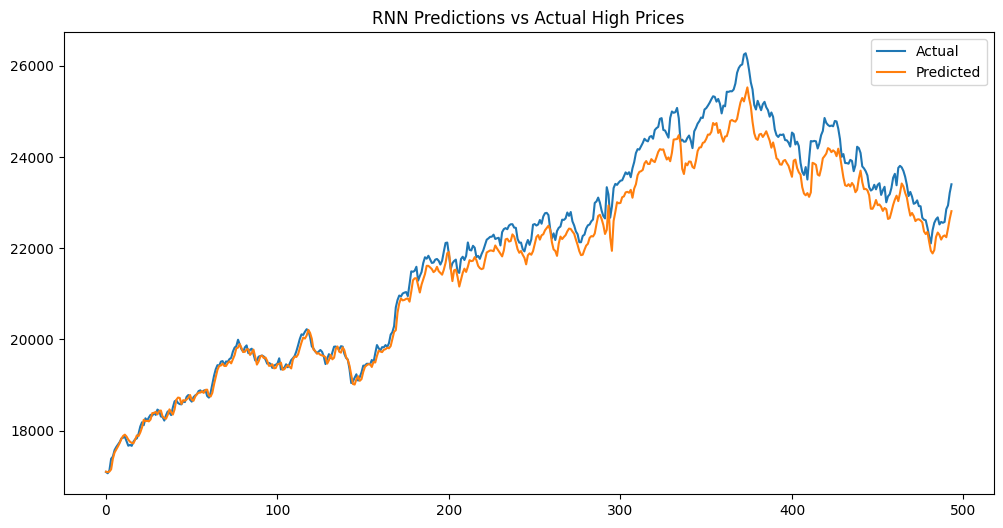

In [ ]:
model.eval()
test_predictions = []

with torch.no_grad():
    for xb, _ in test_loader:
        output = model(xb)
        test_predictions.append(output)

test_predictions = torch.cat(test_predictions, dim=0).numpy()
y_test_actual = scaler_y.inverse_transform(y_test_tensor.numpy().reshape(-1, 1))
predicted_actual = scaler_y.inverse_transform(test_predictions)


import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual')
plt.plot(predicted_actual, label='Predicted')
plt.title('RNN Predictions vs Actual High Prices')
plt.legend()
plt.show()

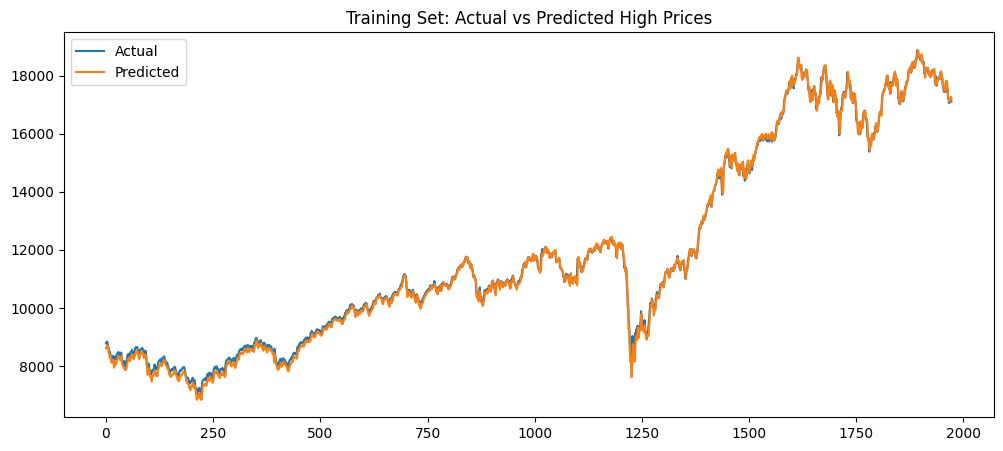

In [ ]:
model.eval()
train_predictions = []

with torch.no_grad():
    for xb, _ in train_loader:
        preds = model(xb)
        train_predictions.append(preds)

train_predictions = torch.cat(train_predictions, dim=0).numpy()
y_train_actual = scaler_y.inverse_transform(y_train_tensor.view(-1, 1).numpy())
train_preds_actual = scaler_y.inverse_transform(train_predictions)

# Plot training predictions
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
plt.plot(y_train_actual, label='Actual')
plt.plot(train_preds_actual, label='Predicted')
plt.title('Training Set: Actual vs Predicted High Prices')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_percentage_error

mean_absolute_percentage_error(predicted_actual, y_test_actual)

0.013919624499976635

In [ ]:
mean_absolute_percentage_error(train_preds_actual, y_train_actual)

0.010378739796578884

In [ ]:
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)

    # Avoid division by zero
    epsilon = np.finfo(np.float64).eps
    y_true_safe = np.where(y_true == 0, epsilon, y_true)

    mape = np.mean(np.abs((y_true - y_pred) / y_true_safe)) * 100
    return mape


In [ ]:
mape_train = mean_absolute_percentage_error(y_train_actual, train_preds_actual)
mape_test = mean_absolute_percentage_error(y_test_actual, predicted_actual)

print(f"Train MAPE: {mape_train:.2f}%")
print(f"Test MAPE: {mape_test:.2f}%")


Train MAPE: 1.15%
Test MAPE: 0.95%


## LSTM Model

In [ ]:
import torch
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout)

        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, return_attn=False):
      h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
      c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

      lstm_out, _ = self.lstm(x, (h0, c0))  # [batch, seq_len, hidden_size]

      return lstm_out

In [ ]:
input_size = X_train.shape[2]  # usually 1 if univariate
hidden_size = 64
num_layers = 2
output_size = 1

model = LSTMModel(input_size, hidden_size, num_layers, output_size)
model.to(device)
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)



In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    loss.backward()
    optimizer.step()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([1973, 1])) that is different to the input size (torch.Size([1973, 10, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (10) must match the size of tensor b (1973) at non-singleton dimension 1

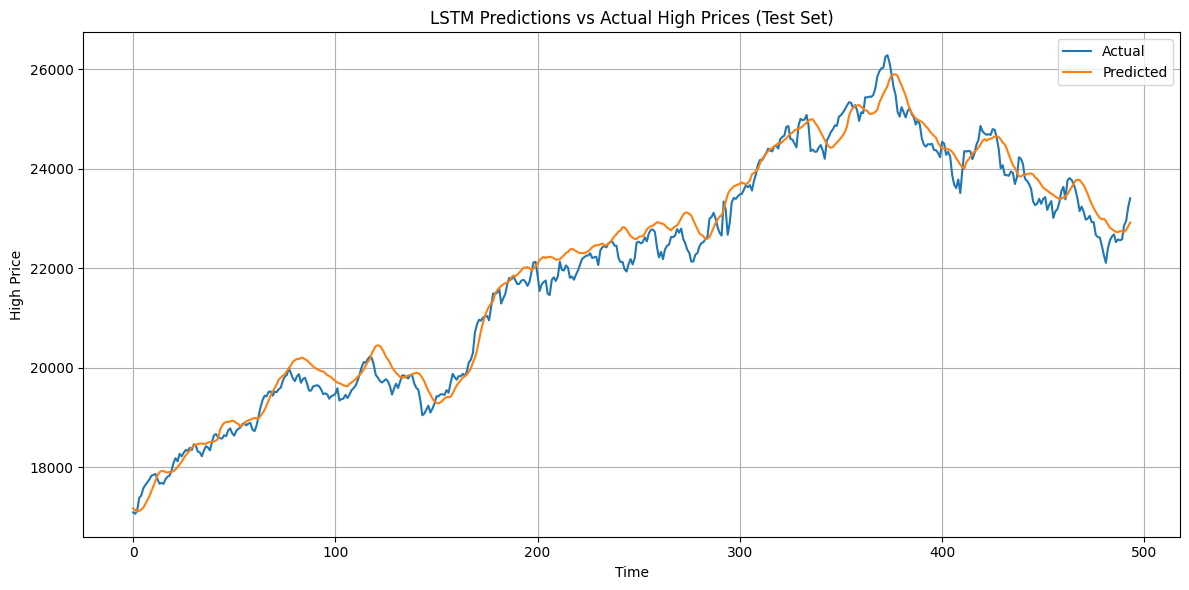

In [ ]:
model.eval()
test_predictions = []

with torch.no_grad():
    for xb, _ in test_loader:
        xb = xb.to(device)  # Move input to same device as model
        output = model(xb)
        test_predictions.append(output.cpu())  # Move output back to CPU for numpy conversion

# Combine all predictions
test_predictions = torch.cat(test_predictions, dim=0).numpy()

# Inverse scale both y_test and predictions
y_test_actual = scaler_y.inverse_transform(y_test_tensor.cpu().numpy().reshape(-1, 1))
predicted_actual = scaler_y.inverse_transform(test_predictions)

# Plot results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual')
plt.plot(predicted_actual, label='Predicted')
plt.title('LSTM Predictions vs Actual High Prices (Test Set)')
plt.xlabel('Time')
plt.ylabel('High Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


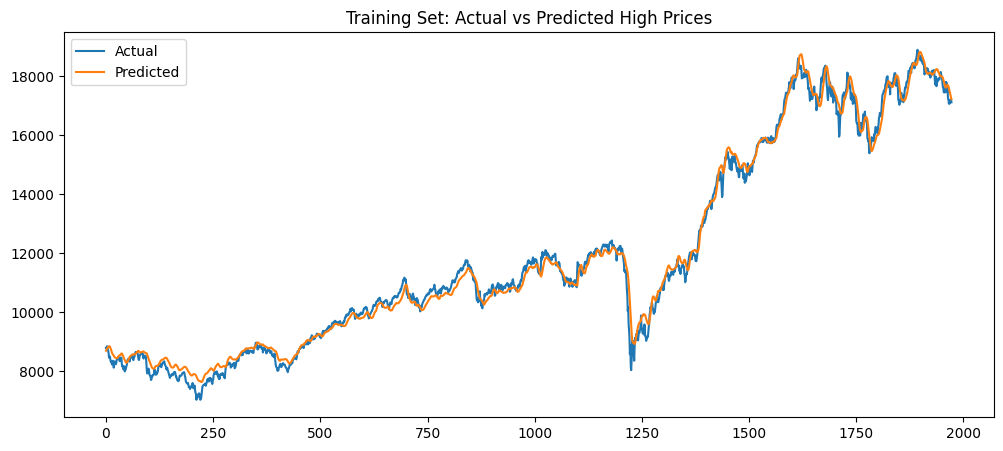

In [ ]:
model.eval()
train_predictions = []

with torch.no_grad():
    for xb, _ in train_loader:
        preds = model(xb)
        train_predictions.append(preds)

train_predictions = torch.cat(train_predictions, dim=0).numpy()
y_train_actual = scaler_y.inverse_transform(y_train_tensor.view(-1, 1).numpy())
train_preds_actual = scaler_y.inverse_transform(train_predictions)

# Plot training predictions
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
plt.plot(y_train_actual, label='Actual')
plt.plot(train_preds_actual, label='Predicted')
plt.title('Training Set: Actual vs Predicted High Prices')
plt.legend()
plt.show()


In [ ]:
mape_train = mean_absolute_percentage_error(y_train_actual, train_preds_actual)
mape_test = mean_absolute_percentage_error(y_test_actual, predicted_actual)

print(f"Train MAPE: {mape_train:.2f}%")
print(f"Test MAPE: {mape_test:.2f}%")


Train MAPE: 1.95%
Test MAPE: 1.19%


## Attention Mechanism + LSTM

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_dim, 1)

    def forward(self, lstm_output):
        # lstm_output: [batch_size, seq_len, hidden_dim]
        attn_weights = F.softmax(self.attn(lstm_output), dim=1)  # [batch, seq_len, 1]
        context = torch.sum(attn_weights * lstm_output, dim=1)   # [batch, hidden_dim]
        return context, attn_weights


class LSTMWithAttention(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(LSTMWithAttention, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout)

        self.attention = Attention(hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, return_attn=False):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        lstm_out, _ = self.lstm(x, (h0, c0))  # [batch, seq_len, hidden_size]
        context, attn_weights = self.attention(lstm_out)

        out = self.fc(context)

        if return_attn:
            return out, attn_weights  # attn_weights: [batch, seq_len, 1]
        else:
            return out



In [ ]:
model = LSTMWithAttention(
    input_size=X_train.shape[2],
    hidden_size=64,
    num_layers=2,
    output_size=1,
    dropout=0.2
).to(device)


In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    loss.backward()
    optimizer.step()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')

Epoch 1/100, Loss: 0.0926
Epoch 2/100, Loss: 0.0820
Epoch 3/100, Loss: 0.0724
Epoch 4/100, Loss: 0.0638
Epoch 5/100, Loss: 0.0562
Epoch 6/100, Loss: 0.0492
Epoch 7/100, Loss: 0.0432
Epoch 8/100, Loss: 0.0378
Epoch 9/100, Loss: 0.0333
Epoch 10/100, Loss: 0.0298
Epoch 11/100, Loss: 0.0275
Epoch 12/100, Loss: 0.0262
Epoch 13/100, Loss: 0.0262
Epoch 14/100, Loss: 0.0271
Epoch 15/100, Loss: 0.0283
Epoch 16/100, Loss: 0.0291
Epoch 17/100, Loss: 0.0288
Epoch 18/100, Loss: 0.0278
Epoch 19/100, Loss: 0.0263
Epoch 20/100, Loss: 0.0247
Epoch 21/100, Loss: 0.0231
Epoch 22/100, Loss: 0.0219
Epoch 23/100, Loss: 0.0210
Epoch 24/100, Loss: 0.0202
Epoch 25/100, Loss: 0.0197
Epoch 26/100, Loss: 0.0191
Epoch 27/100, Loss: 0.0186
Epoch 28/100, Loss: 0.0180
Epoch 29/100, Loss: 0.0173
Epoch 30/100, Loss: 0.0163
Epoch 31/100, Loss: 0.0152
Epoch 32/100, Loss: 0.0139
Epoch 33/100, Loss: 0.0125
Epoch 34/100, Loss: 0.0110
Epoch 35/100, Loss: 0.0097
Epoch 36/100, Loss: 0.0084
Epoch 37/100, Loss: 0.0075
Epoch 38/1

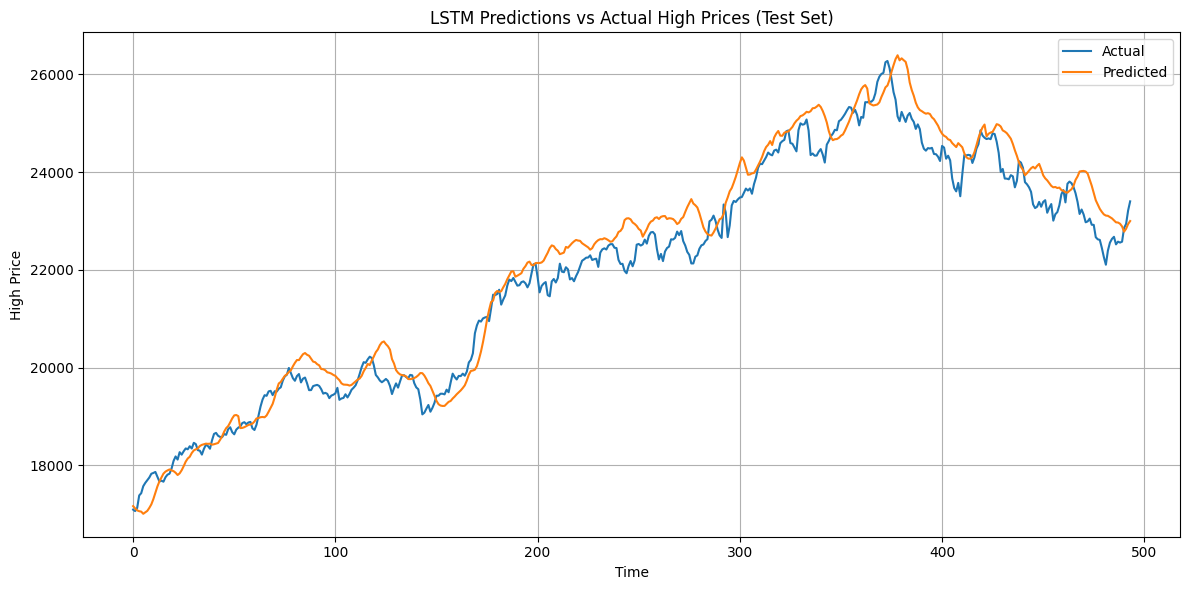

In [ ]:
model.eval()
test_predictions = []
attention_weights = []

with torch.no_grad():
    for xb, _ in test_loader:
        xb = xb.to(device)  # Move input to same device as model
        output, attn = model(xb, return_attn=True)
        test_predictions.append(output.cpu())  # Move output back to CPU for numpy conversion
        attention_weights.append(attn.squeeze(-1).cpu())

# Combine all predictions
test_predictions = torch.cat(test_predictions, dim=0).numpy()
attention_weights = torch.cat(attention_weights, dim=0).numpy()  # shape: (N, seq_len)

# Inverse scale both y_test and predictions
y_test_actual = scaler_y.inverse_transform(y_test_tensor.cpu().numpy().reshape(-1, 1))
predicted_actual = scaler_y.inverse_transform(test_predictions)

# Plot results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual')
plt.plot(predicted_actual, label='Predicted')
plt.title('LSTM Predictions vs Actual High Prices (Test Set)')
plt.xlabel('Time')
plt.ylabel('High Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


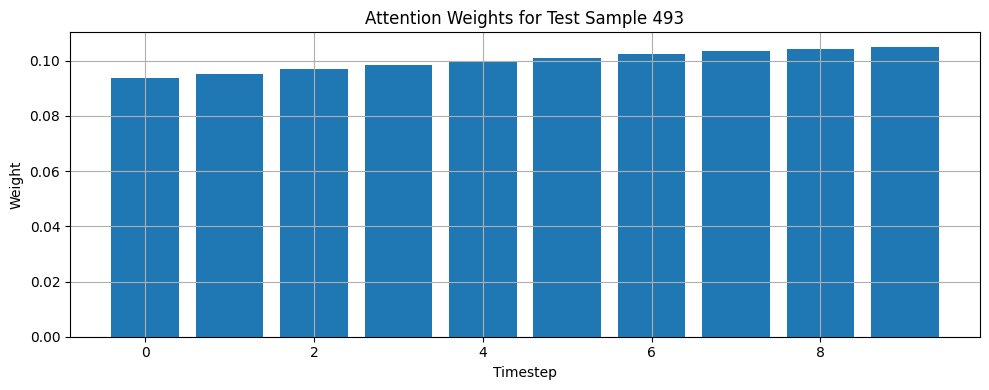

In [ ]:
import matplotlib.pyplot as plt
import random

sample_idx = random.randint(0, len(attention_weights) - 1)

plt.figure(figsize=(10, 4))
plt.bar(range(attention_weights.shape[1]), attention_weights[sample_idx])
plt.title(f"Attention Weights for Test Sample {sample_idx}")
plt.xlabel("Timestep")
plt.ylabel("Weight")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
mean_absolute_percentage_error(y_test_actual, predicted_actual)

0.017671793699264526